### **assumptions about data used by Ledoit and Wolf**
1. 21 consecutive days constitute one month
2. 01.10.1972 to 12.31.2011 data from CSRP is used. (daily stock returns data)
3. Out of sample is considered to be from 01.19.1973 to 12.31.11 (480 months)
4. Portfolios are updated monthly
5. At any investment date h, a coviariance matrix is estimated using the most recent T = 250 daily returns
6. There are a total of 480 months

#steps
1. Consider the given data as population data of all the stocks - we have about 10800 data points for 184 tickers of S&P 500 between 27-10-1981 and 31-12-2022
2. Take blocks of these data and evaluate the assumptions of multiple models as provided by Ledoit and Wolf in the paper Large Dimensional Covariance Matrix Shrinkage
3. Compare results and find significance of these results on an average


In [ ]:
import scipy as sp
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime, timedelta
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install nonlinshrink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import drive and change folders to current folder
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/time_series_analysis_2023/final_implementation")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### load data from pre-populated files, you can also get data from yahoo finance from same dates

In [ ]:
#read data
#dates are from 27-10 not 27-01
import pandas as pd 
prices = pd.read_csv("SandP500_27-01-1981_31-12-2022.csv")
# print(f"stock prices:\n {prices.head()}")
# print(f"stock prices shape:\n {prices.shape}")

returns = pd.read_csv("SandP500_returns_percentage_27-01-1981_31-12-2022.csv")
# print(f"stock percentage returns:\n {returns.head()}")

returns_demeaned = pd.read_csv("SandP500_returns_percentage_demeaned_27-01-1981_31-12-2022.csv")
# print(f"stock percentage demeanend returns:\n {returns_demeaned.head()}")

log_returns = pd.read_csv("SandP500_log_returns_27-01-1981_31-12-2022.csv")
# print(f"stock log returns:\n {log_returns.head()}")

log_returns_demeaned = pd.read_csv("SandP500_returns_log_returns_demeaned_27-01-1981_31-12-2022.csv")
# print(f"log returns demeaned:\n {log_returns_demeaned.head()}")


sp_returns_single = pd.read_csv("sp500_single_log_returns_27-01-1981_31-12-2022.csv")
# print(f"sp500 whole returns:\n {sp_returns_single.head()}")

ff_data = pd.read_csv("ff_daily_data.csv")
# print(f"fama french factors:\n {ff_data.head()}")

from datetime import datetime
def convert_date(date_string):
    date = datetime.strptime(date_string, "%Y-%m-%d") 
    return int(date.strftime("%Y%m%d"))

def convert_to_date(date_string):
    date_string = str(date_string)
    formatted_date = f"{date_string[:4]}-{date_string[4:6]}-{date_string[6:]}"
    return formatted_date

#change all dates to the fama french date format
prices.date = prices.date.apply(convert_date)
returns.date = returns.date.apply(convert_date)
returns_demeaned.date = returns_demeaned.date.apply(convert_date)
log_returns.date = log_returns.date.apply(convert_date)
log_returns_demeaned.date = log_returns_demeaned.date.apply(convert_date)
sp_returns_single.date = sp_returns_single.date.apply(convert_date)
ff_data = ff_data[ff_data['date'].isin(log_returns.date)].reset_index(drop=True)

In [ ]:
#print samples
print("prices:\n",prices.head(2))
print("returns:\n",returns.head(2))
print("returns_demeaned:\n",returns_demeaned.head(2))
print("log_returns:\n",log_returns.head(2))
print("log_returns_demeaned:\n",log_returns_demeaned.head(2))
print("sp_returns_single:\n",sp_returns_single.head(2))
print("ff_data:\n",ff_data.head(2))

In [ ]:
month_trading_days = 21
year_trading_days = month_trading_days*12
total_months = returns.shape[0]/21
#total universes is months starting from 1 year after the beginning date
total_universes = int((returns.shape[0]-year_trading_days)/month_trading_days)
print(f"total_universes: { total_universes}")
print(f"total_months given: { total_months}")
print(f"number of days required for 494 months:{21*494}")

total_universes: 482
total_months given: 494.3809523809524
number of days required for 494 months:10374


In [ ]:
log_returns.columns[prices.isnull().any()]

Index([], dtype='object')

In [ ]:
#modify this <- i use percentage changes everywhere. 
#I discard logarithmic changes due to the inability to use them in factor models
log_returns = pd.read_csv("SandP500_returns_percentage_27-01-1981_31-12-2022.csv")
log_returns.date = log_returns.date.apply(convert_date)

# print(f"stock percentage returns:\n {returns.head()}")

## run below block for all covariance calculation functions 

## **list all ways to compute covariance matrices**

-- defined functions
1. *Ledoit-Wolf libaries*
  1. *Linear Shrinkage*
      1. **cov1Para** (Covariance 1 parameter -> variances same and covariances to zero)
      2. **cov2Para** (2 parameter model - all variance are same and all covarainces are same)
      3. **covCor** (Constant-correlation matrix;)
      4. **covDiag** -> (preserves diagonal of sample)
      5. **covMarket** -> (shrinkage towards one factor model)

   2. Non-Linear Shrinkage
      1. **LIS** (linear inverse shrinkage)
      2. **QIS** (Quadratic inverse shrinkage)
      3. **GIS** (Geometric inverse shrinkage) 

2. From SkLearn
  1. **LedoitWolf**
  2. **ShrunkCovariance**
  3. **OAS** (Oracle Approximate Shrinkage) 

3. Own/ Collected Built libaries
  1. **equal_weight** (equal weightage) -> sigma becomes 1
  2. **sample_cov** (takes covariance of sample)
  3. **lin_shrink** (use linear shrinkage from sklearn's 
  4. **non_lin_shrink**
  5. **single_factor**
  6. **FamaFrench**
  7. **POET**
  8. **NLSF**



In [ ]:
#get functions from ledoit-wolf
#Imports
import numpy as np
import pandas as pd
import math


# -*- coding: utf-8 -*-
"""
Created on Sun Oct  3 17:59:28 2021

@author: Patrick Ledoit
"""

#Sigmahat function
def GIS(Y,k=None):
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    #Set df dimensions
    N = Y.shape[0]                                              #num of columns
    p = Y.shape[1]                                                 #num of rows

    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                      # adjust effective sample size
    c = p/n                                               # concentration ratio

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    sample = (sample+sample.T)/2                              #make symmetrical

    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)            #use Cholesky factorisation 
    #                                               based on hermitian matrix
    lambda1 = lambda1.real.clip(min=0)              #reset negative values to 0
    dfu = pd.DataFrame(u,columns=lambda1)   #create df with column names lambda
    #                                        and values u
    dfu.sort_index(axis=1,inplace = True)              #sort df by column index
    lambda1 = dfu.columns                              #recapture sorted lambda

    #COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c**2,1/c**2)**0.35)/p**0.35                   #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p]  #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]          #like  1/lambda_j
    Lj = pd.DataFrame(Lj.to_numpy())                        #Reset column names
    Lj_i = Lj.subtract(Lj.T)                    #like (1/lambda_j)-(1/lambda_i)
   
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)          #smoothed Stein shrinker
    Htheta = Lj.multiply(Lj*h).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)                    #its conjugate
    Atheta2 = theta**2+Htheta**2                         #its squared amplitude
    
    if p<=n:               #case where sample covariance matrix is not singular
        deltahat_1=(1-c)*invlambda+2*c*invlambda*theta #shrunk inverse eigenvalues (LIS)
        
        delta = 1 / ((1-c)**2*invlambda+2*c*(1-c)*invlambda*theta \
                      +c**2*invlambda*Atheta2)    #optimally shrunk eigenvalues
        delta = delta.to_numpy()
    else: # case where sample covariance matrix is singular
        print('p must be <= n for the Symmetrized Kullback-Leibler divergence')       
        return -1
    
    temp = pd.DataFrame(deltahat_1)
    x = min(invlambda)
    temp.loc[temp[0] < x, 0] = x
    deltaLIS_1 = temp[0]

    temp1 = dfu.to_numpy()
    temp2 = np.diag((delta/deltaLIS_1)**0.5)
    temp3 = dfu.T.to_numpy().conjugate()
    # reconstruct covariance matrix
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3))
    
    return sigmahat


#Sigmahat function
def LIS(Y,k=None):
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    #Set df dimensions
    N = Y.shape[0]                                              #num of columns
    p = Y.shape[1]                                                 #num of rows

    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                      # adjust effective sample size
    c = p/n                                               # concentration ratio

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    sample = (sample+sample.T)/2                              #make symmetrical

    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)            #use Cholesky factorisation 
    #                                               based on hermitian matrix
    lambda1 = lambda1.real.clip(min=0)              #reset negative values to 0
    dfu = pd.DataFrame(u,columns=lambda1)   #create df with column names lambda
    #                                        and values u
    dfu.sort_index(axis=1,inplace = True)              #sort df by column index
    lambda1 = dfu.columns                              #recapture sorted lambda

    #COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c**2,1/c**2)**0.35)/p**0.35                   #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p]  #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]          #like  1/lambda_j
    Lj = pd.DataFrame(Lj.to_numpy())                        #Reset column names
    Lj_i = Lj.subtract(Lj.T)                    #like (1/lambda_j)-(1/lambda_i)
   
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)          #smoothed Stein shrinker
    
    if p<=n:               #case where sample covariance matrix is not singular
         deltahat_1=(1-c)*invlambda+2*c*invlambda*theta #shrunk inverse eigenvalues
         
    else: # case where sample covariance matrix is singular
        print("p must be <= n for Stein's loss")       
        return -1
    
    temp = pd.DataFrame(deltahat_1)
    x = min(invlambda)
    temp.loc[temp[0] < x, 0] = x
    deltaLIS_1 = temp[0]


    temp1 = dfu.to_numpy()
    temp2 = np.diag(1/deltaLIS_1)
    temp3 = dfu.T.to_numpy().conjugate()
    # reconstruct covariance matrix
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3))
    
    return sigmahat

def QIS(Y,k=None):
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    #Set df dimensions
    N = Y.shape[0]                                              #num of columns
    p = Y.shape[1]                                                 #num of rows

    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                      # adjust effective sample size
    c = p/n                                               # concentration ratio

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    sample = (sample+sample.T)/2                              #make symmetrical

    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)            #use Cholesky factorisation 
    #                                               based on hermitian matrix
    lambda1 = lambda1.real.clip(min=0)              #reset negative values to 0
    dfu = pd.DataFrame(u,columns=lambda1)   #create df with column names lambda
    #                                        and values u
    dfu.sort_index(axis=1,inplace = True)              #sort df by column index
    lambda1 = dfu.columns                              #recapture sorted lambda

    #COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c**2,1/c**2)**0.35)/p**0.35                   #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p]  #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]          #like  1/lambda_j
    Lj = pd.DataFrame(Lj.to_numpy())                        #Reset column names
    Lj_i = Lj.subtract(Lj.T)                    #like (1/lambda_j)-(1/lambda_i)
   
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)          #smoothed Stein shrinker
    Htheta = Lj.multiply(Lj*h).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)                    #its conjugate
    Atheta2 = theta**2+Htheta**2                         #its squared amplitude

    if p<=n:               #case where sample covariance matrix is not singular
         delta = 1 / ((1-c)**2*invlambda+2*c*(1-c)*invlambda*theta \
                      +c**2*invlambda*Atheta2)    #optimally shrunk eigenvalues
         delta = delta.to_numpy()
    else:
        delta0 = 1/((c-1)*np.mean(invlambda.to_numpy())) #shrinkage of null 
        #                                                 eigenvalues
        delta = np.repeat(delta0,p-n)
        delta = np.concatenate((delta, 1/(invlambda*Atheta2)), axis=None)

    deltaQIS = delta*(sum(lambda1)/sum(delta))                  #preserve trace
    
    temp1 = dfu.to_numpy()
    temp2 = np.diag(deltaQIS)
    temp3 = dfu.T.to_numpy().conjugate()
    #reconstruct covariance matrix
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3))
    return sigmahat

def cov1Para(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size
    
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    
    # compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    target=meanvar*np.eye(p)
    
    
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    
    
    pihat = sum(piMat.sum())
    

    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    
    # diagonal part of the parameter that we call rho 
    rho_diag=0;
    
    # off-diagonal part of the parameter that we call rho 
    rho_off=0;
    
    # compute shrinkage intensity
    rhohat=rho_diag+rho_off
    kappahat=(pihat-rhohat)/gammahat
    shrinkage=max(0,min(1,kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    
    return sigmahat

def cov2Para(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    
    #compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    meancov = (np.sum(sample.to_numpy()) - np.sum(np.eye(p)*sample.to_numpy()))/(p*(p-1));
    target = pd.DataFrame(meanvar*np.eye(p)+meancov*(1-np.eye(p)))
    
    #estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag = (sample2.sum().sum()-np.trace(sample.to_numpy())**2)/p;
    
    # off-diagonal part of the parameter that we call rho 
    sum1=Y.sum(axis=1)
    sum2=Y2.sum(axis=1)
    temp = (np.multiply(sum1.to_numpy(),sum1.to_numpy())-sum2)
    rho_off1 = np.sum(np.multiply(temp,temp))/(p*n)
    rho_off2 = (sample.sum().sum()-np.trace(sample.to_numpy()))**2/p
    rho_off = (rho_off1-rho_off2)/(p-1)
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat-rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    return sigmahat


def covCor(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import numpy.matlib as mt
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
        
    # compute shrinkage target
    samplevar = np.diag(sample.to_numpy())
    sqrtvar = pd.DataFrame(np.sqrt(samplevar))
    rBar = (np.sum(np.sum(sample.to_numpy()/np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy())))-p)/(p*(p-1)) # mean correlation
    target = pd.DataFrame(rBar*np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy()))
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))];
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    term1 = pd.DataFrame(np.matmul((Y**3).T.to_numpy(),Y.to_numpy())/n)
    term2 = pd.DataFrame(np.transpose(mt.repmat(samplevar,p,1))*sample)
    thetaMat = term1-term2
    thetaMat[np.logical_and(np.eye(p),np.eye(p))] = pd.DataFrame(np.zeros((p,p)))[np.logical_and(np.eye(p),np.eye(p))]
    rho_off = rBar*(np.matmul((1/sqrtvar).to_numpy(),sqrtvar.T.to_numpy())*thetaMat).sum().sum()
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat


def covDiag(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
        
    # compute shrinkage target
    target = pd.DataFrame(np.diag(np.diag(sample.to_numpy())))
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    rho_off = 0
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat

def covMarket(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import numpy.matlib as mt
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     

    #compute shrinkage target
    Ymkt = Y.mean(axis = 1) #equal-weighted market factor
    covmkt = pd.DataFrame(np.matmul(Y.T.to_numpy(),Ymkt.to_numpy()))/n #covariance of original variables with common factor
    varmkt = np.matmul(Ymkt.T.to_numpy(),Ymkt.to_numpy())/n #variance of common factor
    target = pd.DataFrame(np.matmul(covmkt.to_numpy(),covmkt.T.to_numpy()))/varmkt
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))]
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    temp = pd.DataFrame(Y.values*(pd.DataFrame([Ymkt for i in range(p)]).T.values)) #this must perform element wise multiplication but not performing #resolved
    covmktSQ = pd.DataFrame([covmkt[0] for i in range(p)])
    v1 = pd.DataFrame((1/n) * np.matmul(Y2.T.to_numpy(),temp.to_numpy())-np.multiply(covmktSQ.T.to_numpy(),sample.to_numpy()))
    roff1 = (np.sum(np.sum(np.multiply(v1.to_numpy(),covmktSQ.to_numpy())))-np.sum(np.diag(np.multiply(v1.to_numpy(),covmkt.to_numpy()))))/varmkt
    v3 = pd.DataFrame((1/n) * np.matmul(temp.T.to_numpy(),temp.to_numpy()) - varmkt * sample)
    roff3 = (np.sum(np.sum(np.multiply(v3.to_numpy(),np.matmul(covmkt.to_numpy(),covmkt.T.to_numpy())))) - np.sum(np.multiply(np.diag(v3.to_numpy()),(covmkt[0]**2).to_numpy()))) /varmkt**2
    rho_off=2*roff1-roff3
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat


In [ ]:
import numpy as np
import pandas as pd
import nonlinshrink as nls
import time

#define all the other covariances
def equal_weight(log_ret, k=None):
    #default setting
    import numpy as np
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1
    return np.identity(log_ret.shape[1])

def sample_cov(log_ret,k=None):
    #default setting
    import numpy as np
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1
    return np.cov(log_ret.T)

def lin_shrink(log_ret,k=None):
    #default setting
    import numpy as np
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1
    from sklearn.covariance import ledoit_wolf
    return ledoit_wolf(log_ret)[0]   

def non_lin_shrink(log_ret,k=None):
    #default setting
    import numpy as np
    import nonlinshrink as nls
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1
    return nls.shrink_cov(log_ret)      

def single_factor(log_ret,k=None):
    #default setting
    import numpy as np
    import nonlinshrink as nls
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1
    
    #Generate Factor
    equalw=np.array([[1/log_ret.shape[1]]*log_ret.shape[1]])
    # print(log_ret.shape)
    # print(equalw.shape)
    factor=equalw@log_ret.T
    # print(factor)

    #estimate SigmaF
    var_f=np.var(factor,ddof=1)      #variance of factor,
    np.savetxt("SF_factor.csv",factor,delimiter=",")

    #compute cov(Ri,Rf),the covariance of stocks and factor
    var_if=np.cov(log_ret.T,factor)[-1,:-1]
    var_if=np.matrix(var_if)          #convert to 1X100 matrix
    # print("var_if",var_if.shape)

    SigmaSF = (var_if.T*var_if)/log_ret.shape[1]
    # print("SigmaSF",SigmaSF.shape)
    for i in range(log_ret.shape[1]):
        SigmaSF[i,i]=np.cov(log_ret.T)[i,i]

    return SigmaSF

def FamaFrench(log_ret,FFfactors,k=None):

    import numpy as np
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1

    from sklearn.linear_model import LinearRegression
    LG=LinearRegression()
    ### Generate 3-factors array.
    LG.fit(FFfactors,log_ret)      ##FFfactor matirx is a (250,3) matrix!
    betas=LG.coef_

    var_ff=np.cov(FFfactors.T)      ##Covariance of FAMA FRENCH 3 Factor model.

    SigmaF=betas@var_ff@betas.T

    ###As same as SF, the diagonal need add residual,or replace by var(Ri)
    for i in range(log_ret.shape[1]):
        SigmaF[i,i]=np.cov(log_ret.T)[i,i]

    return SigmaF

def POET(log_ret,k=None):
    from sklearn.decomposition import PCA
    import numpy as np
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1

    pca = PCA(n_components=5, copy=True)
    pca.fit(log_ret.T)
    factors=pca.components_


    ##Regression:
    from sklearn.linear_model import LinearRegression
    LG2=LinearRegression()

    LG2.fit(factors.T,log_ret)
    betas=LG2.coef_

    var_fs=np.cov(factors)

    SigmaF=betas@var_fs@betas.T

    ###As same as SF, the diagonal need add residual,or replace by var(Ri)

    for i in range(log_ret.shape[1]):
        SigmaF[i,i]=np.cov(log_ret.T)[i,i]
        
    return SigmaF

def NLSF(log_ret,k=None):
    import numpy as np
    if  k is None or math.isnan(k):
        log_ret = log_ret.sub(log_ret.mean(axis=0), axis=1)                               #demean
        k = 1
    
    SigmaSF = single_factor(log_ret)

    ## NL-SF
    eigenvalue, eigenvectors = np.linalg.eig(SigmaSF)
    
    diag=np.identity(log_ret.shape[1])
    diag2=np.zeros((log_ret.shape[1],log_ret.shape[1]))
    for i in range(log_ret.shape[1]):
        diag[i,i]=pow(eigenvalue[i],-1/2)
        diag2[i,i]=pow(eigenvalue[i],1/2)
    ##Generate Yt x Sigma_SF to the power of -1/2
    SigmaSF2=eigenvectors@diag@eigenvectors.T  ##(1/2)
    SigmaSF3=eigenvectors@diag2@eigenvectors.T  ##(-1/2)
    SigmaC_hat=nls.shrink_cov(log_ret@SigmaSF2)

    #Reincorporating the structure.
    SigmaNLSF=SigmaSF3@SigmaC_hat@SigmaSF3
    return SigmaNLSF

## function based code

In [ ]:
def portfolio_return(mu, weights):
    '''
    Calculate expected portfolio returns for given weights
    '''
    if not len(mu) == len(weights):
        raise ValueError ('shape mismatch: weights and mu must be of same dimension')
        
    return np.dot(mu, weights)

def portfolio_variance(sigma, weights, std=True):
    '''
    Calculate expected portfolio variance (std=False) or standard deviation (std=True)
    '''
    if not len(sigma) == len(weights):
        raise ValueError ('shape mismatch: weights and sigma must be of same dimension')
    
    # print("portfolio_variance")
    # print(weights.T.shape)
    # print(np.array(np.dot(sigma , weights)).flatten().shape)
    variance = np.dot(weights.T, np.array(np.dot(sigma , weights)).flatten())
    
    if std:
        return np.sqrt(variance)
    else:
        return variance

def sharpe_ratio(mu, sigma, weights):
    mu_pf = portfolio_return(mu, weights)
    std_pf = portfolio_variance(sigma, weights)
    return mu_pf/std_pf

def portfolio_stats(mu, sigma, weights, annualize=True, print_out=True):
    if annualize:
        ann_factor = 252
        print_str = 'annual'
    else:
        ann_factor = 1 
        print_str = 'daily'
        
    mu_pf = portfolio_return(mu, weights)*ann_factor
    std_pf = portfolio_variance(sigma, weights)*np.sqrt(ann_factor)
    sharpe = mu_pf/std_pf
    
    if print_out:
        print('Expected {}: \n return: {:.4f} \n volatility: {:.4f} \n Sharpe-ratio: {:.4f}'.format(
        print_str, mu_pf, std_pf, sharpe))
    
    return [mu_pf, std_pf, sharpe]

In [ ]:
"""
functions for calculating weights
1. get_weight_allow_ss to allow for short selling when allocation (weights can be -ve)
2. get_weights_notallow_ss which doesnt allow short selling when allocation (weights are always >=0)
"""
#calculate weights <- using formula from ledoit wolf
def get_weights_allow_ss(covmat): 
    covmat= np.matrix(covmat)
    """
    calcultes the formula for global minimum variance portfolio given a covariance matrix of assets.
    this weight calculation allows for short selling
    """
    #check
    if covmat.shape[0]!= covmat.shape[1]:
        print("Error : covariance matric is not a symmetric matrix, check code. ")
        raise SystemExit(1)
    else:
        weights = (covmat.I@np.ones((covmat.shape[0],1)))/(np.ones((1,covmat.shape[0]))@covmat.I@np.ones((covmat.shape[0],1)))
        return weights

def get_weights_notallow_ss(mu, covmat):
    import scipy as sp
    from scipy.optimize import minimize
    '''
    In this weights method, I do not allow the short selling, i.e. weights are not allowed to be negative
    Mean-variance portfolio optimization with SLSQP
    
    Returns
        Optimal weights
    '''    
    if not isinstance(mu, np.ndarray):
        mu = np.array(mu)        
    
    def objective_f(weights):
        return - sharpe_ratio(mu, covmat, weights)    
    
    n = mu.size
    # print("n shape:",n)

    # Constraints: sum of weights = 1
    cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.})
    # Boundaries: 0 =< weights =< 1 (only long positions)
    bnds = tuple((0, 1) for x in range(n))
    # initial guess: equal weights
    x_0 = np.repeat(1/n, n)
    # Sequential Least SQuares Programming (SLSQP)
    opts = minimize(objective_f, x0=x_0, method='SLSQP', bounds=bnds, constraints=cons)
    # if opts['message'] != 'Optimization terminated successfully.':
    #     print(opts['message'])
    
    def numpy_unflatten(array, position):
        return np.expand_dims(array, axis=position)

    return numpy_unflatten(opts['x'],1)

In [ ]:
def compute_cov(log_ret,FF_factors):

    # print("=========calculating linear shrinkage versions=============")
    linear_covar=[]
    linear_covar.append(cov1Para(log_ret))
    # print(linear_covar[0].shape)
    linear_covar.append(cov2Para(log_ret))
    # print(linear_covar[1].shape)
    linear_covar.append(covCor(log_ret))
    # print(linear_covar[2].shape)
    linear_covar.append(covDiag(log_ret))
    # print(linear_covar[3].shape)
    linear_covar.append(covMarket(log_ret))
    # print(linear_covar[4].shape)
    
    # print("=========calculating non-linear shrinkage versions=============")
    non_linear_covar=[]
    non_linear_covar.append(LIS(log_ret))
    # print(non_linear_covar[0].shape)
    non_linear_covar.append(QIS(log_ret))
    # print(non_linear_covar[1].shape)
    non_linear_covar.append(GIS(log_ret))
    # print(non_linear_covar[2].shape)
    
    # print("=========calculating paper shrinkage versions=============")
    
    """
    1. equal_weight
    2. sample_cov
    3. lin_shrink
    4. non_lin_shrink
    5. single_factor
    6. FamaFrench
    7. NLSF
    8. POET
    """
    other_covar = []
    other_covar.append(equal_weight(log_ret))
    # print(other_covar[0].shape)
    other_covar.append(sample_cov(log_ret))
    # print(other_covar[1].shape)
    other_covar.append(lin_shrink(log_ret))
    # print(other_covar[2].shape)
    other_covar.append(non_lin_shrink(log_ret))
    # print(other_covar[3].shape)
    other_covar.append(single_factor(log_ret))
    # print(other_covar[4].shape)
    other_covar.append(FamaFrench(log_ret,FF_factors))
    # print(other_covar[5].shape)
    other_covar.append(POET(log_ret))
    # print(other_covar[7].shape)
    other_covar.append(NLSF(log_ret))
    # print(other_covar[6].shape)

    return linear_covar, non_linear_covar, other_covar

In [ ]:
%%time 
from tqdm import tqdm
#calcuate covariance matrices for each universe 
month_trading_days = 21
year_trading_days = month_trading_days*12
total_months = returns.shape[0]/21
#total universes is months starting from 1 year after the beginning date
total_universes = int((returns.shape[0]-year_trading_days)/month_trading_days)
print(f"total_universes: { total_universes}")
print(f"total_months given: { total_months}")
print(f"number of days required for 494 months:{21*494}")

SEED = 42 
import random
random.seed(SEED)

def train_and_predict(N,learn_days,test_days,log_returns,k):

    def flat_list(input_list):
      import itertools
      return list(itertools.chain.from_iterable(input_list))

    """
    define the lists that accumulate all the neccessary values
    """
    #####Linear####### including short selling and not including short selling
    linearss1 = []
    linearss2 = []
    linearss3 = []
    linearss4 = []
    linearss5 = []

    linearnss1 = []
    linearnss2 = []
    linearnss3 = []
    linearnss4 = []
    linearnss5 = []

    #####Non - Linear####### including short selling and not including short selling
    non_linearss1 = []
    non_linearss2 = []
    non_linearss3 = []
    
    non_linearnss1 = []
    non_linearnss2 = []
    non_linearnss3 = []
    
    #####From Paper####### including short selling and not including short selling
    otherss1 = []
    otherss2 = []
    otherss3 = []
    otherss4 = []
    otherss5 = []
    otherss3 = []
    otherss4 = []
    otherss5 = []
    otherss6 = []
    otherss7 = []
    otherss8 = []

    othernss1 = []
    othernss2 = []
    othernss3 = []
    othernss4 = []
    othernss5 = []
    othernss3 = []
    othernss4 = []
    othernss5 = []
    othernss6 = []
    othernss7 = []
    othernss8 = []

    ############## weights dictionaries with time###############
    weights_lss1 = []
    weights_lss2 = []
    weights_lss3 = []
    weights_lss4 = []
    weights_lss5 = []

    weights_lnss1 = []
    weights_lnss2 = []
    weights_lnss3 = []
    weights_lnss4 = []
    weights_lnss5 = []

    ##non-linear###
    weigthts_nlss1 = []
    weigthts_nlss2 = []
    weigthts_nlss3 = []

    weigthts_nlnss1 = []
    weigthts_nlnss2 = []
    weigthts_nlnss3 = []

    #paper weights###
    weights_oss1 = []
    weights_oss2 = []
    weights_oss3 = []
    weights_oss4 = []
    weights_oss5 = []
    weights_oss6 = []
    weights_oss7 = []
    weights_oss8 = []

    weights_onss1 = []
    weights_onss2 = []
    weights_onss3 = []
    weights_onss4 = []
    weights_onss5 = []
    weights_onss6 = []
    weights_onss7 = []
    weights_onss8 = []


    """
    take 
    N = assets we want to predict fot
    learn_days = how many days are considered to be sample for learning
    test_days = how many days we test our prediction (these are the window days, or in real life, how often do we restrategize)
    """
    import pandas as pd
    import random
    print(f"stocks_chosen:{N},\n learning_days: {learn_days},\n test_days: {test_days},\n, out of total best:{k} ")
    linear_returns=[]
    non_linear_returns = []
    def get_random_tickers(df, row_index, N, K):
        """
        Randomly select N stock tickers out of every K top-performing stocks based on a given row.

        Args:
            df (pd.DataFrame): DataFrame with column names representing stock tickers.
            row_index (int): Index of the row to consider for selecting stocks.
            N (int): Number of stock tickers to select.
            K (int): Number of top-performing stocks to consider.

        Returns:
            list: List of randomly selected stock tickers.
        """
        # print("row_index:",row_index)
        row_values = df.iloc[row_index]
        sorted_values = row_values.sort_values(ascending=False)
        top_k_tickers = sorted_values[:K].index.tolist()
        selected_tickers = random.sample(top_k_tickers, N)
        return selected_tickers
        
    universes = int((log_returns.shape[0]-learn_days)/test_days)
    for universe in tqdm(range(universes)):
        # print("universe:", universe+1)
        tickers = get_random_tickers(log_returns.iloc[:,1:],learn_days+(universe+1)*test_days,N,k)
        
        in_sample = log_returns.loc[universe*test_days:((universe*test_days)+learn_days)-1,tickers].copy()
        """
        ff data already is daily data so, no need to worry about it. do not do any unnecessary modifications
        """
        ff_factors = ff_data.iloc[universe*test_days:((universe*test_days)+learn_days), 1:-1].copy()

        out_of_sample = returns.loc[(universe*test_days)+learn_days:((universe+1)*test_days)+learn_days-1, tickers].copy()
        # print("out_of_sample mean",len(out_of_sample.mean().values))

        rf_data = ff_data.iloc[(universe*test_days)+learn_days:((universe+1)*test_days)+learn_days,-1].copy()
        rf_data = np.array(rf_data).T
        #print(rf_data.shape) #shape is 21,

        # compute covariance using all the listed models
        linear_covar, non_linear_covar, paper_covar = compute_cov(in_sample,ff_factors)
        for i,linear in enumerate(linear_covar):
            weights_ss = get_weights_allow_ss(linear).T
            real_returns_ss = np.matmul(weights_ss,out_of_sample.values.T)
            weights_no_ss = get_weights_notallow_ss(out_of_sample.mean().values,linear).T
            real_returns_no_ss = np.matmul(weights_no_ss,out_of_sample.values.T)
            market_return_ss = flat_list((real_returns_ss-rf_data).tolist())
            market_retuns_nss = flat_list((real_returns_no_ss-rf_data).tolist())
            weights_ss_dict = dict(zip(tickers,np.array(weights_ss).flatten().tolist()))
            weights_nss_dict = dict(zip(tickers,np.array(weights_no_ss).flatten().tolist()))

            #calculate and append returns and weight dictionaries for each iteration
            if i+1 == 1:
                linearss1+=market_return_ss
                linearnss1+=market_retuns_nss
                weights_lss1.append(weights_ss_dict)
                weights_lnss1.append(weights_nss_dict)

            if i+1 == 2:
                linearss2+=market_return_ss
                linearnss2+=market_retuns_nss
                weights_lss2.append(weights_ss_dict)
                weights_lnss2.append(weights_nss_dict)

            if i+1 == 3:
                linearss3+=market_return_ss
                linearnss3+=market_retuns_nss
                weights_lss3.append(weights_ss_dict)
                weights_lnss3.append(weights_nss_dict)
            
            if i+1 == 4:
                linearss4+=market_return_ss
                linearnss4+=market_retuns_nss
                weights_lss4.append(weights_ss_dict)
                weights_lnss4.append(weights_nss_dict)

            if i+1 == 5:
                linearss5+=market_return_ss
                linearnss5+=market_retuns_nss
                weights_lss5.append(weights_ss_dict)
                weights_lnss5.append(weights_nss_dict)

        for i,non_lin in enumerate(non_linear_covar):
            weights_ss = get_weights_allow_ss(non_lin).T
            real_returns_ss = np.matmul(weights_ss,out_of_sample.values.T)
            weights_no_ss = get_weights_notallow_ss(out_of_sample.mean().values,non_lin).T
            real_returns_no_ss = np.matmul(weights_no_ss,out_of_sample.values.T)
            market_return_ss = flat_list((real_returns_ss-rf_data).tolist())
            market_retuns_nss = flat_list((real_returns_no_ss-rf_data).tolist())
            weights_ss_dict = dict(zip(tickers,np.array(weights_ss).flatten().tolist()))
            weights_nss_dict = dict(zip(tickers,np.array(weights_no_ss).flatten().tolist()))
            
            if i+1 == 1:
                non_linearss1+=market_return_ss
                non_linearnss1+=market_retuns_nss
                weigthts_nlss1.append(weights_ss_dict)
                weigthts_nlnss1.append(weights_nss_dict)

            if i+1 == 2:
                non_linearss2+=market_return_ss
                non_linearnss2+=market_retuns_nss
                weigthts_nlss2.append(weights_ss_dict)
                weigthts_nlnss2.append(weights_nss_dict)

            if i+1 == 3:
                non_linearss3+=market_return_ss
                non_linearnss3+=market_retuns_nss
                weigthts_nlss3.append(weights_ss_dict)
                weigthts_nlnss3.append(weights_nss_dict) 

        for i,other in enumerate(paper_covar):
            weights_ss = get_weights_allow_ss(other).T
            real_returns_ss = np.matmul(weights_ss,out_of_sample.values.T)
            weights_no_ss = get_weights_notallow_ss(out_of_sample.mean().values,other).T
            real_returns_no_ss = np.matmul(weights_no_ss,out_of_sample.values.T)
            market_return_ss = flat_list((real_returns_ss-rf_data).tolist())
            market_retuns_nss = flat_list((real_returns_no_ss-rf_data).tolist())
            weights_ss_dict = dict(zip(tickers,np.array(weights_ss).flatten().tolist()))
            weights_nss_dict = dict(zip(tickers,np.array(weights_no_ss).flatten().tolist()))
            #calculate and append returns and weight dictionaries for each iteration
            if i+1 == 1:
                otherss1+=market_return_ss
                othernss1+=market_retuns_nss
                weights_oss1.append(weights_ss_dict)
                weights_onss1.append(weights_nss_dict)

            if i+1 == 2:
                otherss2+=market_return_ss
                othernss2+=market_retuns_nss
                weights_oss2.append(weights_ss_dict)
                weights_onss2.append(weights_nss_dict)

            if i+1 == 3:
                otherss3+=market_return_ss
                othernss3+=market_retuns_nss
                weights_oss3.append(weights_ss_dict)
                weights_onss3.append(weights_nss_dict)
            
            if i+1 == 4:
                otherss4+=market_return_ss
                othernss4+=market_retuns_nss
                weights_oss4.append(weights_ss_dict)
                weights_onss4.append(weights_nss_dict)

            if i+1 == 5:
                otherss5+=market_return_ss
                othernss5+=market_retuns_nss
                weights_oss5.append(weights_ss_dict)
                weights_onss5.append(weights_nss_dict)
            
            if i+1 == 6:
                otherss6+=market_return_ss
                othernss6+=market_retuns_nss
                weights_oss6.append(weights_ss_dict)
                weights_onss6.append(weights_nss_dict)
            
            if i+1 == 7:
                otherss7+=market_return_ss
                othernss7+=market_retuns_nss
                weights_oss7.append(weights_ss_dict)
                weights_onss7.append(weights_nss_dict)

            if i+1 == 8:
                otherss8+=market_return_ss
                othernss8+=market_retuns_nss
                weights_oss8.append(weights_ss_dict)
                weights_onss8.append(weights_nss_dict)
    
    #create dataframes and return for the sample
    # print(len(linearss1),  len(linearss2),  len(linearss3),len(linearss4), len(linearss5), len(non_linearss1), len(non_linearss2),
    #       len(non_linearss3),len(otherss1),len(otherss2),len(otherss3),len(otherss4),len(otherss5),
    #       len(otherss6),len(otherss7),len(otherss8))

    return_columns = ["cov1Para","cov2Para","covCor","covDiag","covMarket","LIS","QIS","GIS","equal_weight","sample_cov","lin_shrink","non_lin_shrink","single_factor","FamaFrench","POET","NLSF"]
    ss_dummy = np.stack((linearss1,
              linearss2,
              linearss3,
              linearss4,
              linearss5,
              non_linearss1,
              non_linearss2,
              non_linearss3,
              otherss1,
              otherss2,
              otherss3,
              otherss4,
              otherss5,
              otherss6,
              otherss7,
              otherss8)).T
    
    nss_dummy = np.stack((linearnss1,
              linearnss2,
              linearnss3,
              linearnss4,
              linearnss5,
              non_linearnss1,
              non_linearnss2,
              non_linearnss3,
              othernss1,
              othernss2,
              othernss3,
              othernss4,
              othernss5,
              othernss6,
              othernss7,
              othernss8)).T

    ss_weights_dummy = [weights_lss1,
                        weights_lss2,
                        weights_lss3,
                        weights_lss4,
                        weights_lss5,
                        weigthts_nlss1,
                        weigthts_nlss2,
                        weigthts_nlss3,
                        weights_oss1,
                        weights_oss2,
                        weights_oss3,
                        weights_oss4,
                        weights_oss5,
                        weights_oss6,
                        weights_oss7,
                        weights_oss8]

    nss_weights_dummy = [weights_lnss1,
                          weights_lnss2,
                          weights_lnss3,
                          weights_lnss4,
                          weights_lnss5,
                          weigthts_nlnss1,
                          weigthts_nlnss2,
                          weigthts_nlnss3,
                          weights_onss1,
                          weights_onss2,
                          weights_onss3,
                          weights_onss4,
                          weights_onss5,
                          weights_onss6,
                          weights_onss7,
                          weights_onss8]

    ss_df = pd.DataFrame(ss_dummy,columns = return_columns)
    # print(ss_df.head())
    nss_df = pd.DataFrame(nss_dummy,columns = return_columns)
    # print(nss_df.head())

    ss_weights_df = pd.DataFrame(ss_weights_dummy).T
    ss_weights_df.columns = return_columns

    nss_weights_df = pd.DataFrame(nss_weights_dummy).T
    nss_weights_df.columns = return_columns

    return ss_df, nss_df, ss_weights_df, nss_weights_df

total_universes: 482
total_months given: 494.3809523809524
number of days required for 494 months:10374
CPU times: user 2.08 ms, sys: 0 ns, total: 2.08 ms
Wall time: 2.09 ms


In [ ]:
#here I am passing returns data which is percentage data from the earlier population direclt

hund_ss_df, hund_nss_df, hund_ss_weights_df, hund_nss_weights_df = train_and_predict(100,year_trading_days,month_trading_days,returns,150)
fifty_ss_df, fifty_nss_df, fifty_ss_weights_df, fifty_nss_weights_df = train_and_predict(50,year_trading_days,month_trading_days,returns,150)
thirty_ss_df, thirty_nss_df, thirty_ss_weights_df, thirty_nss_weights_df = train_and_predict(30,year_trading_days,month_trading_days,returns,150)

stocks_chosen:100,
 learning_days: 252,
 test_days: 21,
, out of total best:150 


100%|██████████| 482/482 [46:41<00:00,  5.81s/it]


stocks_chosen:50,
 learning_days: 252,
 test_days: 21,
, out of total best:150 


100%|██████████| 482/482 [13:03<00:00,  1.62s/it]


stocks_chosen:30,
 learning_days: 252,
 test_days: 21,
, out of total best:150 


100%|██████████| 482/482 [07:11<00:00,  1.12it/s]


In [ ]:
def plot_return_values(df, columns, dates = pd.Series(returns["date"][252:252+hund_ss_df.shape[0]].values)):
    
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")
    
    df = df[columns]
    df["date"]= dates.apply(convert_to_date)

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Create a color palette with distinct colors
    color_palette = plt.cm.Set1.colors[:df.shape[1]]

    # Plot columns with distinct colors and adjust the line width
    df.plot(color=color_palette, lw=2)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    plt.show()

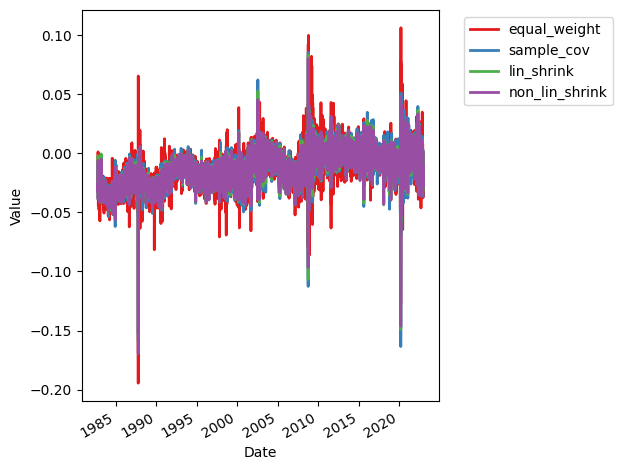

In [ ]:
# -> choose out of these columns
#"cov1Para","cov2Para","covCor","covDiag","covMarket","LIS","QIS","GIS","equal_weight","sample_cov","lin_shrink","lin_shrink","single_factor","FamaFrench","POET","NLSF"]]
plot_columns = ["equal_weight","sample_cov","lin_shrink","non_lin_shrink"]

#function to plot return values
"""
1.takes the dataframe
2.takes the columns (here the strategies used), 
3. if you want to give different dates, you can but not needed as long as you are plotting for all the days - 10112
"""
plot_return_values(hund_ss_df,plot_columns)

In [ ]:
#get the final returns of all the values per columns
def get_avg_returns(df,days= 252):
    """
    this function takes dataframe and puts together the annual return overall of each column
    """
    mean_df = df.mean()
    mean_df.columns = df.columns
    mean_df = mean_df*days
    return mean_df

def get_stdev(df,days= 252):
    std_df = df.std()*(days**(0.5))
    return std_df

In [ ]:
#all the dataframe
all_dfs = ["hund_ss_df", "hund_nss_df", "fifty_ss_df", "fifty_nss_df","thirty_ss_df", "thirty_nss_df"]

#put all data into single dataframe
average_all_dfs = pd.DataFrame()
average_all_dfs = pd.concat([average_all_dfs,get_avg_returns(hund_ss_df).to_frame()],axis=1)
average_all_dfs = pd.concat([average_all_dfs,get_avg_returns(hund_nss_df).to_frame()],axis=1)
average_all_dfs = pd.concat([average_all_dfs,get_avg_returns(fifty_ss_df).to_frame()],axis=1)
average_all_dfs = pd.concat([average_all_dfs,get_avg_returns(fifty_nss_df).to_frame()],axis=1)
average_all_dfs = pd.concat([average_all_dfs,get_avg_returns(thirty_ss_df).to_frame()],axis=1)
average_all_dfs = pd.concat([average_all_dfs,get_avg_returns(thirty_nss_df).to_frame()],axis=1)

average_all_dfs.columns = all_dfs

display(average_all_dfs)
display(pd.concat([average_all_dfs.idxmax(), average_all_dfs.max()],axis=1))

,hund_ss_df,hund_nss_df,fifty_ss_df,fifty_nss_df,thirty_ss_df,thirty_nss_df
cov1Para,-3.212151,-1.769701,-3.222992,-1.902201,-3.194976,-2.043717
cov2Para,-3.210608,-1.631455,-3.221167,-1.804637,-3.195722,-1.979195
covCor,-3.229437,-1.705674,-3.233650,-1.860737,-3.193991,-2.020136
covDiag,-3.216571,-1.796164,-3.226604,-1.928460,-3.192619,-2.064246
covMarket,-3.222368,-1.775579,-3.232848,-1.900143,-3.196385,-2.041085
LIS,-3.217282,-1.756310,-3.228816,-1.894051,-3.197214,-2.040091
QIS,-3.217259,-1.747178,-3.228919,-1.890232,-3.197314,-2.038586
GIS,-3.217276,-1.751755,-3.228866,-1.892171,-3.197264,-2.039349
equal_weight,-3.175017,-2.226032,-3.175282,-2.235917,-3.171963,-2.294425
sample_cov,-3.216488,-1.779975,-3.229384,-1.911421,-3.193986,-2.047976


,0,1
hund_ss_df,equal_weight,-3.175017
hund_nss_df,cov2Para,-1.631455
fifty_ss_df,equal_weight,-3.175282
fifty_nss_df,cov2Para,-1.804637
thirty_ss_df,equal_weight,-3.171963
thirty_nss_df,cov2Para,-1.979195


In [ ]:
#all the dataframe
all_dfs = ["hund_ss_df", "hund_nss_df", "fifty_ss_df", "fifty_nss_df","thirty_ss_df", "thirty_nss_df"]

#put all data into single dataframe
stdev_all_dfs = pd.DataFrame()
stdev_all_dfs = pd.concat([stdev_all_dfs,get_stdev(hund_ss_df).to_frame()],axis=1)
stdev_all_dfs = pd.concat([stdev_all_dfs,get_stdev(hund_nss_df).to_frame()],axis=1)
stdev_all_dfs = pd.concat([stdev_all_dfs,get_stdev(fifty_ss_df).to_frame()],axis=1)
stdev_all_dfs = pd.concat([stdev_all_dfs,get_stdev(fifty_nss_df).to_frame()],axis=1)
stdev_all_dfs = pd.concat([stdev_all_dfs,get_stdev(thirty_ss_df).to_frame()],axis=1)
stdev_all_dfs = pd.concat([stdev_all_dfs,get_stdev(thirty_nss_df).to_frame()],axis=1)

stdev_all_dfs.columns = all_dfs

display(stdev_all_dfs)
display(pd.concat([stdev_all_dfs.idxmin(), stdev_all_dfs.min()],axis=1))

,hund_ss_df,hund_nss_df,fifty_ss_df,fifty_nss_df,thirty_ss_df,thirty_nss_df
cov1Para,0.210487,0.315856,0.214879,0.307583,0.218166,0.296329
cov2Para,0.209776,0.329713,0.214511,0.320598,0.217865,0.304633
covCor,0.209782,0.325483,0.214855,0.316699,0.218101,0.300753
covDiag,0.211207,0.313965,0.215570,0.304824,0.218286,0.295149
covMarket,0.208485,0.318048,0.213842,0.309483,0.217684,0.298590
LIS,0.209449,0.317774,0.214402,0.310137,0.218192,0.297818
QIS,0.209336,0.319175,0.214356,0.310867,0.218203,0.298106
GIS,0.209380,0.318456,0.214376,0.310449,0.218197,0.297955
equal_weight,0.243772,0.273443,0.245543,0.280860,0.246180,0.273572
sample_cov,0.217248,0.316982,0.217878,0.308354,0.220119,0.297882


,0,1
hund_ss_df,covMarket,0.208485
hund_nss_df,single_factor,0.247435
fifty_ss_df,NLSF,0.213768
fifty_nss_df,single_factor,0.257838
thirty_ss_df,covMarket,0.217684
thirty_nss_df,single_factor,0.258894


In [ ]:
import pandas as pd
import scipy.stats as stats

def hypothesis_test(df, target_col, compare_cols):
    target_std = df[target_col].std()
    compare_stds = [df[col].std() for col in compare_cols]

    # Perform one-sample t-test comparing the target column's standard deviation against the other columns
    _, p_value = stats.ttest_1samp(compare_stds, target_std)

    # Print results
    print("Null Hypothesis: The standard deviation of column '{}' is not significantly lower than other columns".format(target_col))
    print("Alternative Hypothesis: The standard deviation of column '{}' is significantly lower than other columns".format(target_col))
    print("")

    if p_value < 0.05:
        print("Result: Reject the null hypothesis")
        print("Conclusion: The standard deviation of column '{}' is significantly lower than other columns".format(target_col))
    else:
        print("Result: Fail to reject the null hypothesis")
        print("Conclusion: The standard deviation of column '{}' is not significantly lower than other columns".format(target_col))
    print("p-value: ", p_value)

hypothesis_column = "non_lin_shrink"
comparison_columns = ["cov1Para","cov2Para"]

hypothesis_test(hund_ss_df,hypothesis_column,comparison_columns )

Null Hypothesis: The standard deviation of column 'non_lin_shrink' is not significantly lower than other columns
Alternative Hypothesis: The standard deviation of column 'non_lin_shrink' is significantly lower than other columns

Result: Fail to reject the null hypothesis
Conclusion: The standard deviation of column 'non_lin_shrink' is not significantly lower than other columns
p-value:  0.2959048935139657


## **Ledoit Wolf Provided Functions**
- 2003 - Flexible multivariate GARCH modelling with an application to international stock markets
- 2003 - Improved estimation of covariance matrix of stock returns with an applicaiton in portfolio selection
- 2004 - A well conditioned estimator for large dimensional covariance matrices
- 2004 - Honey, I shrunk sample covariance matrix
- 2019 - Large Dynamic Covariance Matrices
- 2020 - Analytical non-linear shrinkage of large dimensional covariance matrices 
- 2022 - Quadratic shrinkage for large covariance matrices

### implementations from ledoit and wolf in python available

> INPUT(S): Y (N*p): raw data matrix of N iid observations on p random variables. Second optional input parameter: If the second (optional) parameter k is absent, not-a-number, or empty,then the algorithm demeans the data by default, and adjusts the effective sample size accordingly. If the user inputs k = 0, then no demeaning takes place; if user inputs k = 1, then it signifies that the data Y has already been demeaned.

Correction: In the term of matrices: 
The input matrix should be of format (T time stamp rows * N stocks as columns)
Here N defined above is N time period and p as stocks.

NONLINEAR SHRINKAGE: 


> 6) GIS.m: Nonlinear shrinkage derived under the Symmetrized Kullback-Leibler loss, called geometric-inverse shrinkage (GIS). It can be viewed as geometrically averaging linear-inverse shrinkage (LIS) with quadratic-inverse shrinkage (QIS). See Ledoit and Wolf (2021, Remark 4.3).


> 7) LIS.m: Nonlinear shrinkage derived under Stein’s loss, called linear-inverse shrinkage (LIS). See Ledoit and Wolf (2021, Section 3). 
8) QIS.m: Nonlinear shrinkage derived under Frobenius loss and its two cousins, Inverse Stein’s loss and Minimum Variance loss, called quadratic-inverse shrinkage (QIS). See Ledoit and Wolf (2021, Section 4.5).

In [ ]:
#read available data
import pandas as pd
FF_u1 = pd.read_csv('data/FF_universe1.csv')
df =pd.read_csv('data/stocks100_u1.csv')

FF_u2= pd.read_csv('data/FF_universe2.csv')
stocks_u2=pd.read_csv('data/stocks100_u2.csv')

In [ ]:
#print and inspect imported dataframe
df =pd.read_csv('data/stocks100_u1.csv')
print(df.head())
print(df.shape)

Implements the geometric-inverse shrinkage (GIS) estimator 

In [ ]:
# implementation  order
def calc_covar(df,K=None):
    print("===================================================================\n")
    print("Non-linear methods being calcualted:\n\n")
    sigma_2_GIS = GIS(df, k=K)
    """
    Explanation: called Geometric Inverse Shrinkage
      This is a nonlinear shrinkage estimator based on the Symmetrized 
      Kullback-Leibler loss; it can be viewed as geometrically averaging
      linear-inverse shrinkage (LIS) with quadratic-inverse shrinkage (QIS)

    """
    print("covariance using GIS is calcualted\n")
    sigma_2_LIS = LIS(df, k=K)
    print("covariance using LIS is calcualted\n")
    sigma_2_QIS = QIS(df, k=K)
    print("covariance using QIS is calcualted\n\n")

    print("===================================================================\n")
    print("Linear methods being calcualted:\n\n")
    sigma_2_cov1Para = cov1Para(df, k=K)
    print("covariance using 1 parameter is calcualted")
    sigma_2_cov2Para = cov2Para(df, k=K)
    print("covariance using 2 parameter is calcualted")
    sigma_2_covCor = covCor(df, k=K)
    print("covariance using correlation is calcualted")
    sigma_2_covDiag = covDiag(df, k=K)
    print("covariance using Diagonal is calcualted")
    sigma_2_covMarket = covMarket(df, k=K)
    print("covariance using Market is calcualted")

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct  3 17:59:28 2021

@author: Patrick Ledoit
"""

# function sigmahat=GIS(Y,k) 
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Implements the geometric-inverse shrinkage (GIS) estimator  
#    This is a nonlinear shrinkage estimator based on the Symmetrized
#    Kullback-Leibler loss; it can be viewed as geometrically averaging
#    linear-inverse shrinkage (LIS) with quadratic-inverse shrinkage (QIS)
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data Y has
# already been demeaned.
#
# This version: 01/2021

### EXTRACT sample eigenvalues sorted in ascending order and eigenvectors ###

#Imports
import numpy as np
import pandas as pd
import math

#Sigmahat function
def GIS(Y,k=None):
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    #Set df dimensions
    N = Y.shape[0]                                              #num of columns
    p = Y.shape[1]                                                 #num of rows

    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                      # adjust effective sample size
    # print(f"N, sample size, total number of time periods of the sample: {N}")
    # print(f"p, paramters size, total number of assets (stocks chosen) in the sample: {p}")

    # print(f"n, adjsuted sample size:{n}")
    c = p/n                                               # concentration ratio
    # print(f"c, concentration ratio:{c}")

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    sample = (sample+sample.T)/2                              #make symmetrical

    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)            #use Cholesky factorisation 
    #                                               based on hermitian matrix
    lambda1 = lambda1.real.clip(min=0)              #reset negative values to 0
    dfu = pd.DataFrame(u,columns=lambda1)   #create df with column names lambda
    #                                        and values u
    dfu.sort_index(axis=1,inplace = True)              #sort df by column index
    lambda1 = dfu.columns                              #recapture sorted lambda

    #COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c**2,1/c**2)**0.35)/p**0.35                   #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p]  #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]          #like  1/lambda_j
    Lj = pd.DataFrame(Lj.to_numpy())                        #Reset column names
    Lj_i = Lj.subtract(Lj.T)                    #like (1/lambda_j)-(1/lambda_i)
   
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)          #smoothed Stein shrinker
    Htheta = Lj.multiply(Lj*h).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)                    #its conjugate
    Atheta2 = theta**2+Htheta**2                         #its squared amplitude
    
    if p<=n:               #case where sample covariance matrix is not singular
        deltahat_1=(1-c)*invlambda+2*c*invlambda*theta #shrunk inverse eigenvalues (LIS)
        
        delta = 1 / ((1-c)**2*invlambda+2*c*(1-c)*invlambda*theta \
                      +c**2*invlambda*Atheta2)    #optimally shrunk eigenvalues
        delta = delta.to_numpy()
    else: # case where sample covariance matrix is singular
        print('p must be <= n for the Symmetrized Kullback-Leibler divergence')       
        return -1
    
    temp = pd.DataFrame(deltahat_1)
    x = min(invlambda)
    temp.loc[temp[0] < x, 0] = x
    deltaLIS_1 = temp[0]

    temp1 = dfu.to_numpy()
    temp2 = np.diag((delta/deltaLIS_1)**0.5)
    temp3 = dfu.T.to_numpy().conjugate()
    # reconstruct covariance matrix
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3))
    
    return sigmahat

# df = pd.read_csv(r'C:\Users\Patrick Ledoit\Documents\Python\translation\input1.csv')
df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)

df = df.astype(float)
sigmahat = GIS(df,k=1)
display(sigmahat)

Implements the linear-inverse shrinkage (LIS) estimator  

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct  3 17:18:14 2021

@author: Patrick Ledoit
"""

# function sigmahat=LIS(Y,k) 
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Implements the linear-inverse shrinkage (LIS) estimator  
#    This is a nonlinear shrinkage estimator derived under on Stein's loss
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data Y has
# already been demeaned.
#
# This version: 01/2021

### EXTRACT sample eigenvalues sorted in ascending order and eigenvectors ###

#Imports
import numpy as np
import pandas as pd
import math

#Sigmahat function
def LIS(Y,k=None):
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    #Set df dimensions
    N = Y.shape[0]                                              #num of columns
    p = Y.shape[1]                                                 #num of rows

    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                      # adjust effective sample size
    c = p/n                                               # concentration ratio

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    sample = (sample+sample.T)/2                              #make symmetrical

    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)            #use Cholesky factorisation 
    #                                               based on hermitian matrix
    lambda1 = lambda1.real.clip(min=0)              #reset negative values to 0
    dfu = pd.DataFrame(u,columns=lambda1)   #create df with column names lambda
    #                                        and values u
    dfu.sort_index(axis=1,inplace = True)              #sort df by column index
    lambda1 = dfu.columns                              #recapture sorted lambda

    #COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c**2,1/c**2)**0.35)/p**0.35                   #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p]  #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]          #like  1/lambda_j
    Lj = pd.DataFrame(Lj.to_numpy())                        #Reset column names
    Lj_i = Lj.subtract(Lj.T)                    #like (1/lambda_j)-(1/lambda_i)
   
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)          #smoothed Stein shrinker
    
    if p<=n:               #case where sample covariance matrix is not singular
         deltahat_1=(1-c)*invlambda+2*c*invlambda*theta #shrunk inverse eigenvalues
         
    else: # case where sample covariance matrix is singular
        print("p must be <= n for Stein's loss")       
        return -1
    
    temp = pd.DataFrame(deltahat_1)
    x = min(invlambda)
    temp.loc[temp[0] < x, 0] = x
    deltaLIS_1 = temp[0]


    temp1 = dfu.to_numpy()
    temp2 = np.diag(1/deltaLIS_1)
    temp3 = dfu.T.to_numpy().conjugate()
    # reconstruct covariance matrix
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3))
    
    return sigmahat

df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().T.reset_index(drop=True)
df = df.astype(float)

sigmahat = LIS(df,k=1)
display(sigmahat)

Implements the quadratic-inverse shrinkage (QIS) estimator 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 11 15:18:30 2021

@author: Patrick Ledoit
"""

#Imports
import numpy as np
import pandas as pd
import math

# function sigmahat=QIS(Y,k) 
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Implements the quadratic-inverse shrinkage (QIS) estimator  
#    This is a nonlinear shrinkage estimator derived under the Frobenius loss
#    and its two cousins, Inverse Stein's loss and Mininum Variance loss
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data Y has
# already been demeaned.
#
# This version: 01/2021

def QIS(Y,k=None):
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned

    #Set df dimensions
    N = Y.shape[0]                                              #num of columns
    p = Y.shape[1]                                                 #num of rows

    #default setting
    if (k is None or math.isnan(k)):
        Y = Y.sub(Y.mean(axis=0), axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                      # adjust effective sample size
    c = p/n                                               # concentration ratio

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    sample = (sample+sample.T)/2                              #make symmetrical

    #Spectral decomp
    lambda1, u = np.linalg.eigh(sample)            #use Cholesky factorisation 
    #                                               based on hermitian matrix
    lambda1 = lambda1.real.clip(min=0)              #reset negative values to 0
    dfu = pd.DataFrame(u,columns=lambda1)   #create df with column names lambda
    #                                        and values u
    dfu.sort_index(axis=1,inplace = True)              #sort df by column index
    lambda1 = dfu.columns                              #recapture sorted lambda

    #COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c**2,1/c**2)**0.35)/p**0.35                   #smoothing parameter
    invlambda = 1/lambda1[max(1,p-n+1)-1:p]  #inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values,min(p,n))]          #like  1/lambda_j
    Lj = pd.DataFrame(Lj.to_numpy())                        #Reset column names
    Lj_i = Lj.subtract(Lj.T)                    #like (1/lambda_j)-(1/lambda_i)
   
    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)          #smoothed Stein shrinker
    Htheta = Lj.multiply(Lj*h).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj)*h**2)).mean(axis = 0)                    #its conjugate
    Atheta2 = theta**2+Htheta**2                         #its squared amplitude

    if p<=n:               #case where sample covariance matrix is not singular
         delta = 1 / ((1-c)**2*invlambda+2*c*(1-c)*invlambda*theta \
                      +c**2*invlambda*Atheta2)    #optimally shrunk eigenvalues
         delta = delta.to_numpy()
    else:
        delta0 = 1/((c-1)*np.mean(invlambda.to_numpy())) #shrinkage of null 
        #                                                 eigenvalues
        delta = np.repeat(delta0,p-n)
        delta = np.concatenate((delta, 1/(invlambda*Atheta2)), axis=None)

    deltaQIS = delta*(sum(lambda1)/sum(delta))                  #preserve trace
    
    temp1 = dfu.to_numpy()
    temp2 = np.diag(deltaQIS)
    temp3 = dfu.T.to_numpy().conjugate()
    #reconstruct covariance matrix
    sigmahat = pd.DataFrame(np.matmul(np.matmul(temp1,temp2),temp3))
    return sigmahat

df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)
df = df.astype(float)

sigmahat = QIS(df,k=1)
display(sigmahat)

cov1Para: Linear shrinkage towards one-parameter matrix; all the variances are the same, all the covariances are zero. See Ledoit and Wolf (2004b).

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul  8 20:21:58 2021

@author: Patrick Ledoit
"""

# function sigmahat=cov1Para(Y,k)
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Shrinks towards one-parameter matrix:
#    all variances of the target are the same
#    all covariances of the target are zero
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data x has
# already been demeaned.
#
# This version: 01/2021, based on the 04/2014 version

def cov1Para(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size
    
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    
    # compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    target=meanvar*np.eye(p)
    
    
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    
    
    pihat = sum(piMat.sum())
    

    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    
    # diagonal part of the parameter that we call rho 
    rho_diag=0;
    
    # off-diagonal part of the parameter that we call rho 
    rho_off=0;
    
    # compute shrinkage intensity
    rhohat=rho_diag+rho_off
    kappahat=(pihat-rhohat)/gammahat
    shrinkage=max(0,min(1,kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    
    return sigmahat

import pandas as pd
df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)
df = df.astype(float)

sigmahat = cov1Para(df)
display(sigmahat)

cov2Para: Linear shrinkage towards two-parameter matrix; all the variances are the same, all the covariances are the same. See Ledoit (1995, Appendix B.1).

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 29 16:08:52 2021

@author: Patrick Ledoit
"""

# function sigmahat=cov2Para(Y,k)
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Shrinks towards two-parameter matrix:
#    all variances of the target are the same as one another
#    all covariances of the target are the same as one another
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data Y has
# already been demeaned.
#
# This version: 01/2021, based on the 06/2009 version


def cov2Para(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    
    #compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    meancov = (np.sum(sample.to_numpy()) - np.sum(np.eye(p)*sample.to_numpy()))/(p*(p-1));
    target = pd.DataFrame(meanvar*np.eye(p)+meancov*(1-np.eye(p)))
    
    #estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag = (sample2.sum().sum()-np.trace(sample.to_numpy())**2)/p;
    
    # off-diagonal part of the parameter that we call rho 
    sum1=Y.sum(axis=1)
    sum2=Y2.sum(axis=1)
    temp = (np.multiply(sum1.to_numpy(),sum1.to_numpy())-sum2)
    rho_off1 = np.sum(np.multiply(temp,temp))/(p*n)
    rho_off2 = (sample.sum().sum()-np.trace(sample.to_numpy()))**2/p
    rho_off = (rho_off1-rho_off2)/(p-1)
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat-rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    return sigmahat
    
import pandas as pd
df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)
df = df.astype(float)

sigmahat = cov2Para(df)
display(sigmahat)

covCor: Linear shrinkage towards constant-correlation matrix; the target preserves the diagonal of the sample covariance matrix and all correlation coefficients are the same. See Ledoit and Wolf (2004a).

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 29 17:08:18 2021

@author: Patrick Ledoit
"""


# function sigmahat=covCor(Y,k)
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Shrinks towards constant-correlation matrix:
#    the target preserves the variances of the sample covariance matrix
#    all the correlation coefficients of the target are the same
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data Y has
# already been demeaned.
#
# This version: 01/2021, based on the 04/2014 version

def covCor(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import numpy.matlib as mt
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
        
    # compute shrinkage target
    samplevar = np.diag(sample.to_numpy())
    sqrtvar = pd.DataFrame(np.sqrt(samplevar))
    rBar = (np.sum(np.sum(sample.to_numpy()/np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy())))-p)/(p*(p-1)) # mean correlation
    target = pd.DataFrame(rBar*np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy()))
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))];
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    term1 = pd.DataFrame(np.matmul((Y**3).T.to_numpy(),Y.to_numpy())/n)
    term2 = pd.DataFrame(np.transpose(mt.repmat(samplevar,p,1))*sample)
    thetaMat = term1-term2
    thetaMat[np.logical_and(np.eye(p),np.eye(p))] = pd.DataFrame(np.zeros((p,p)))[np.logical_and(np.eye(p),np.eye(p))]
    rho_off = rBar*(np.matmul((1/sqrtvar).to_numpy(),sqrtvar.T.to_numpy())*thetaMat).sum().sum()
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat

import pandas as pd
df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)
df = df.astype(float)

sigmahat = covCor(df)
display(sigmahat)

covDiag: Linear shrinkage towards diagonal matrix; the target preserves the diagonal of the sample covariance matrix and all the covariances are zero. See Ledoit (1995, Appendix B.2).

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 12 16:07:10 2021

@author: Patrick Ledoit
"""


# function sigmahat=covCor(Y,k)
#
# Y (N*p): raw data matrix of N iid observations on p random variables
# sigmahat (p*p): invertible covariance matrix estimator
#
# Shrinks towards constant-correlation matrix:
#    the target preserves the variances of the sample covariance matrix
#    all the correlation coefficients of the target are the same
#
# If the second (optional) parameter k is absent, not-a-number, or empty,
# then the algorithm demeans the data by default, and adjusts the effective
# sample size accordingly. If the user inputs k = 0, then no demeaning
# takes place; if (s)he inputs k = 1, then it signifies that the data Y has
# already been demeaned.
#
# This version: 01/2021, based on the 04/2014 version

def covDiag(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
        
    # compute shrinkage target
    target = pd.DataFrame(np.diag(np.diag(sample.to_numpy())))
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    rho_off = 0
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat

import pandas as pd
df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)
df = df.astype(float)

sigmahat = covDiag(df)
display(sigmahat)

covMarket: Linear shrinkage towards a one-factor market model, where the factor is defined as the cross-sectional average of all the random variables; thanks to the idiosyncratic volatility of the residuals, the target preserves the diagonal of the sample covariance matrix. See Ledoit and Wolf (2003).

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 12 16:17:27 2021

@author: Patrick Ledoit
"""
def covMarket(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    import numpy as np
    import numpy.matlib as mt
    import pandas as pd
    import math

    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     

    #compute shrinkage target
    Ymkt = Y.mean(axis = 1) #equal-weighted market factor
    covmkt = pd.DataFrame(np.matmul(Y.T.to_numpy(),Ymkt.to_numpy()))/n #covariance of original variables with common factor
    varmkt = np.matmul(Ymkt.T.to_numpy(),Ymkt.to_numpy())/n #variance of common factor
    target = pd.DataFrame(np.matmul(covmkt.to_numpy(),covmkt.T.to_numpy()))/varmkt
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))]
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    temp = pd.DataFrame(Y.values*(pd.DataFrame([Ymkt for i in range(p)]).T.values)) #this must perform element wise multiplication but not performing #resolved
    covmktSQ = pd.DataFrame([covmkt[0] for i in range(p)])
    v1 = pd.DataFrame((1/n) * np.matmul(Y2.T.to_numpy(),temp.to_numpy())-np.multiply(covmktSQ.T.to_numpy(),sample.to_numpy()))
    roff1 = (np.sum(np.sum(np.multiply(v1.to_numpy(),covmktSQ.to_numpy())))-np.sum(np.diag(np.multiply(v1.to_numpy(),covmkt.to_numpy()))))/varmkt
    v3 = pd.DataFrame((1/n) * np.matmul(temp.T.to_numpy(),temp.to_numpy()) - varmkt * sample)
    roff3 = (np.sum(np.sum(np.multiply(v3.to_numpy(),np.matmul(covmkt.to_numpy(),covmkt.T.to_numpy())))) - np.sum(np.multiply(np.diag(v3.to_numpy()),(covmkt[0]**2).to_numpy()))) /varmkt**2
    rho_off=2*roff1-roff3
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat
    
import pandas as pd
df =pd.read_csv('data/stocks100_u1.csv')
df = df.iloc[:,1:]
# df = df.T.reset_index().reset_index(drop=True)
df = df.astype(float)

sigmahat = covMarket(df,k=1)
display(sigmahat)

## code with part of ledoit -wolf data 2017 experiment

In [ ]:
##Package-----------------------------------

import numpy as np
import pandas as pd
import nonlinshrink as nls
import time

def showmatrixinfo(matrix):
    print("Matrix shape: ",np.shape(matrix))
    print(matrix)
    return
    

##-------Test Function---------------------##

def test_result(omega,method):
    
    ### Use estimated covariance matrix to calculate w
    Omega= np.matrix(omega)
    w=(Omega.I@np.ones((100,1)))/(np.ones((1,100))@Omega.I@np.ones((100,1)))
    
    ###########calculate payoff and excess payoff(ri-rf)
    
    payoff=w.T@yt_test*100
    
    exc_payoff=payoff-rf_daily*100
    print("\t"+method+" complete!")
    
    
    return exc_payoff.tolist()[0]

##-------------Covariance Estimation----------------------##

def run_1N():
    N=100
    omega=np.identity(100)

    return1N=test_result(omega,"1/N")
    return return1N

def run_Samp():
    ## ---------Sample Covariance Estimation
    omega=np.cov(yt_est)

    returnSamp=test_result(omega,"Samp")
    return returnSamp
    
def run_Lin():
    ##--------Lin(Ledoit-Wolf 2004 methpd) shrinkage Estimation
    from sklearn.covariance import ledoit_wolf

    omega=ledoit_wolf(yt_est.T)[0]

    returnLin=test_result(omega,"Lin")
    return returnLin

##-------NonLin shrinkage Estimation--------------

def run_NonLin():
    import nonlinshrink as nls

    omega=nls.shrink_cov(yt_est.T)

    returnNonLin=test_result(omega,"NonLin")
    return returnNonLin

##--------Single factor estimation---------------------##

def run_SF():
    ##   Generate Factor
    equalw=np.array([[0.01]*100])
    factor=equalw@yt_est

    ##estimate SigmaF
    var_f=np.var(factor,ddof=1)      #variance of factor,

    np.savetxt("SF_factor.csv",factor,delimiter=",")

    ##compute cov(Ri,Rf),the covariance of stocks and factor
    var_if=np.cov(yt_est,factor)[-1,:-1]
    var_if=np.matrix(var_if)          #convert to 1X100 matrix


    SigmaSF=var_if.T*var_if/var_f  
    for i in range(100):
        SigmaSF[i,i]=np.cov(yt_est)[i,i]

        
    returnSF=test_result(SigmaSF,"SF")
    return returnSF,SigmaSF

##-----------------FAMA FRENCH estimation------------------------

def run_FF():
    #####First, Generate 3-factors array.


    from sklearn.linear_model import LinearRegression

    LG=LinearRegression()

    LG.fit(FFfactors,yt_est.T)      ##FFfactor matirx is a (250,3) matrix!
    betas=LG.coef_

    var_ff=np.cov(FFfactors.T)      ##Covariance of FAMA FRENCH 3 Factor model.

    SigmaF=betas@var_ff@betas.T

    ###As same as SF, the diagonal need add residual,or replace by var(Ri)

    for i in range(100):
        SigmaF[i,i]=np.cov(yt_est)[i,i]

    returnFF=test_result(SigmaF,"FF")
    return returnFF


def run_POET():

#---------POET estimation-----------------#
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=5, copy=True)
    pca.fit(yt_est)
    factors=pca.components_


    ##Regression:
    from sklearn.linear_model import LinearRegression

    LG2=LinearRegression()

    LG2.fit(factors.T,yt_est.T)
    betas=LG2.coef_

    var_fs=np.cov(factors)

    SigmaF=betas@var_fs@betas.T

    ###As same as SF, the diagonal need add residual,or replace by var(Ri)

    for i in range(100):
        SigmaF[i,i]=np.cov(yt_est)[i,i]
        
        
    returnPOET=test_result(SigmaF,"POET")
    return returnPOET

def run_NLSF(SigmaSF):
    ## NL-SF
    eigenvalue, eigenvectors = np.linalg.eig(SigmaSF)
    
    diag=np.identity(100)
    diag2=np.zeros((100,100))
    for i in range(100):
        diag[i,i]=pow(eigenvalue[i],-1/2)
        diag2[i,i]=pow(eigenvalue[i],1/2)
    ##Generate Yt x Sigma_SF to the power of -1/2
    SigmaSF2=eigenvectors@diag@eigenvectors.T  ##(1/2)
    SigmaSF3=eigenvectors@diag2@eigenvectors.T  ##(-1/2)
    SigmaC_hat=nls.shrink_cov(yt_est.T@SigmaSF2)

    #Reincorporating the structure.
    SigmaNLSF=SigmaSF3@SigmaC_hat@SigmaSF3
    returnNLSF=test_result(SigmaNLSF,"NL-SF")
    return returnNLSF


##------------Initialize-------------------#
start=time.time()

return1N=[]
returnSamp=[]
returnLin=[]
returnNonLin=[]
returnSF=[]
returnFF=[]
returnPOET=[]
returnNLSF=[]

def run(fulldata):
    yt_est=fulldata[0]
    yt_test=fulldata[1]
    FFdata=fulldata[2]
    
    return1N.extend(run_1N())
    returnSamp.extend(run_Samp())
    returnLin.extend(run_Lin())
    returnNonLin.extend(run_NonLin())
    returnSF.extend(run_SF()[0])
    returnFF.extend(run_FF())
    returnPOET.extend(run_POET())
    returnNLSF.extend(run_NLSF(run_SF()[1]))
    
    return


#####--------------Running test----------------------------------#

##------Data import-------------------------
FF_u1 = pd.read_csv('data/FF_universe1.csv')
stocks_u1=pd.read_csv('data/stocks100_u1.csv')

FF_u2= pd.read_csv('data/FF_universe2.csv')
stocks_u2=pd.read_csv('data/stocks100_u2.csv')

#-------------Iteration---------------------

FF_u=FF_u1
stocks_u=stocks_u1

for i in range(230):
    print("\nTetst "+str(i+1)+" starts!")

    FFdata = FF_u.iloc[i*21:271+i*21,]

    stocksdata=stocks_u.iloc[i*21:271+i*21,1:101].to_numpy()
    yt_est=stocksdata[:250,].T
    yt_test=stocksdata[250:,].T

    index=["Mkt-RF","SMB","HML"]
    FFfactors=FFdata.loc[:,index].iloc[:250,].to_numpy()
    rf_rate=FFdata.loc[:,"RF"].iloc[250:,].to_numpy()
    rf_daily=rf_rate/250                          

    data=[yt_est,yt_test,FFdata]
    run(data)
    print("Test "+str(i+1)+" complete!")


print("Universe 1 Complete!")

FF_u=FF_u2
stocks_u=stocks_u2

for i in range(230):
    print("\nTetst "+str(i+231)+" starts!")

    FFdata = FF_u.iloc[i*21:271+i*21,]

    stocksdata=stocks_u.iloc[i*21:271+i*21,1:101].to_numpy()
    yt_est=stocksdata[:250,].T
    yt_test=stocksdata[250:,].T

    index=["Mkt-RF","SMB","HML"]
    FFfactors=FFdata.loc[:,index].iloc[:250,].to_numpy()
    rf_rate=FFdata.loc[:,"RF"].iloc[250:,].to_numpy()
    rf_daily=rf_rate/250                          

    data=[yt_est,yt_test,FFdata]
    run(data)
    print("Test "+str(i+231)+" complete!")


print("Universe 2 Complete!")



ret_mat=np.array([return1N,returnSamp,returnLin,returnNonLin,returnSF,returnFF,returnPOET,returnNLSF])

print("Return maxtrix:")
print(np.shape(ret_mat))


##----------------Calculating and plotting results------------------##

AV=np.mean(ret_mat,axis=1)*250
AV=AV.T.tolist()

SD=np.std(ret_mat,axis=1)*pow(250,.5)
SD=SD.T.tolist()

SR=[]
for i in range(len(SD)):
    SR.append(AV[i]/SD[i])

def prtb():
    print("Table 1")
    print("Performance measures for various estimators of the GMV portfolio")
    print("{}".format('''Period: January 19, 1973 to December 31, 2011" '''))
    print("\t1/N \tSample \tLin \tNolin \tSF \tFF \tPOET \tNL-SF")
    print("{:-^70}".format(""))
    print("{:^70}".format("N=100"))
    print("{:-^70}".format(""))
    print("AV \t{:.2f} \t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        AV[0],AV[1],AV[2],AV[3],AV[4],AV[5],AV[6],AV[7])
    )
    print("SD \t{:.2f} \t{:.2f}\t{:.2f}\t{:.2f}\t{:.1f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        SD[0],SD[1],SD[2],SD[3],SD[4],SD[5],SD[6],SD[7]))
    print("SR \t{:.2f} \t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        SR[0],SR[1],SR[2],SR[3],SR[4],SR[5],SR[6],SR[7]))
    print("{:-^70}".format(""))

        
    return


prtb()

end=time.time()

tm=end-start
print("Total running time:"+str(tm)+" Seconds")

Streaming output truncated to the last 5000 lines.
	POET complete!
	SF complete!
	NL-SF complete!
Test 45 complete!

Tetst 46 starts!
	1/N complete!
	Samp complete!
	Lin complete!
	NonLin complete!
	SF complete!
	FF complete!
	POET complete!
	SF complete!
	NL-SF complete!
Test 46 complete!

Tetst 47 starts!
	1/N complete!
	Samp complete!
	Lin complete!
	NonLin complete!
	SF complete!
	FF complete!
	POET complete!
	SF complete!
	NL-SF complete!
Test 47 complete!

Tetst 48 starts!
	1/N complete!
	Samp complete!
	Lin complete!
	NonLin complete!
	SF complete!
	FF complete!
	POET complete!
	SF complete!
	NL-SF complete!
Test 48 complete!

Tetst 49 starts!
	1/N complete!
	Samp complete!
	Lin complete!
	NonLin complete!
	SF complete!
	FF complete!
	POET complete!
	SF complete!
	NL-SF complete!
Test 49 complete!

Tetst 50 starts!
	1/N complete!
	Samp complete!
	Lin complete!
	NonLin complete!
	SF complete!
	FF complete!
	POET complete!
	SF complete!
	NL-SF complete!
Test 50 complete!

Tetst 51

# code to see R workings in Non-Linear Shrinkage directly

> The following cell give the nonlinear shrinkage from R library which is assumed to be more accurate and uses the QUEsT working of Ledoit and Wolf. Python version comaprison for the same data provides a very slight deviation (measured in frobenius loss terms) in the order of 0.00016187904158080588.

> While the error may be big or small based on how this will impact the overall estimation, I consciously ignore this and go ahead with python implemetation. If you want to get an accurate estimation, I suggest you to use the R implementation completely for the program. Even better, if you use Julia.



In [ ]:
!pip install rpy2 --upgrade
#import drive and change folders to current folder
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/time_series_analysis_2023/final_implementation")


import pandas as pd
import numpy as np

log_returns = pd.read_csv("SandP500_log_returns_27-01-1981_31-12-2022.csv")
# print(f"stock log returns:\n {log_returns.head()}")


import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri, numpy2ri
pandas2ri.activate()

# Load required R packages
nlshrink = rpackages.importr("nlshrink")
df = log_returns.iloc[:252,1:101]
# Convert pandas DataFrame to numpy array
np_array = df.astype(float).to_numpy()

# Convert numpy array to R matrix
r_matrix = numpy2ri.py2rpy(np_array)

# Call the R function with the matrix as an argument
result = nlshrink.nlshrink_cov(r_matrix)

# Convert the result back to a pandas DataFrame
result_df = pd.DataFrame(np.array(result))


# Print the result DataFrame
print(result_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estimating population eigenvalues...          0         1         2         3         4         5         6   \
0   0.000283  0.000114  0.000103  0.000100  0.000060  0.000098  0.000082   
1   0.000114  0.000343  0.000090  0.000110  0.000071  0.000099  0.000079   
2   0.000103  0.000090  0.000440  0.000122  0.000046  0.000093  0.000062   
3   0.000100  0.000110  0.000122  0.000445  0.000071  0.000104  0.000112   
4   0.000060  0.000071  0.000046  0.000071  0.000463  0.000084  0.000127   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.000097  0.000081  0.000113  0.000089  0.000064  0.000093  0.000084   
96  0.000049  0.000065  0.000071  0.000050  0.000042  0.000058  0.000089   
97  0.000058  0.000070  0.000059  0.000076  0.000069  0.000070  0.000083   
98  0.000071  0.000073  0.000029  0.000102  0.000042  0.000102  0.000102   